In [57]:
import sys
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl



In [35]:
start = "2019-01-01"
end = "2019-12-31"

SP500_daily = yf.download("^GSPC", start, end)['Close']
HANGSENG_daily = yf.download("^HSI", start, end)['Close']
ShanghaiSE_daily = yf.download("000001.SS", start, end)['Close']
KOSPI_daily = yf.download("^KS11", start, end)['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [39]:
tickers = ["SP500", "HANGSENG", "Shanghai", "KOSPI"]

df = pd.concat([SP500_daily, HANGSENG_daily, ShanghaiSE_daily, KOSPI_daily], axis=1)
df.columns = tickers
df.dropna(inplace=True)

In [40]:
ret_daily = df.pct_change()
ret_annual = ret_daily.mean() * 250
cov_daily = ret_daily.cov()
cov_annual = cov_daily * 250

In [41]:
from scipy.optimize import minimize

def obj_sharpe(weights, returns, covmat, rf):
    ret = np.dot(weights, returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))
    return 1/((ret-rf)/np.sqrt(vol))


In [47]:
n_assets = len(tickers)
covmat=cov_daily*250
rf = 0.01
weights = np.ones([n_assets])/n_assets

bnds = tuple((0., 1.) for i in range(n_assets))
cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}) 
res = minimize(obj_sharpe, weights,(ret_annual, covmat, rf), method='SLSQP', bounds=bnds, constraints=cons)

In [48]:
print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.264264315980473
       x: [ 8.093e-01  0.000e+00  1.907e-01  4.077e-17]
     nit: 5
     jac: [-6.784e-01 -2.510e-01 -6.788e-01 -2.745e-01]
    nfev: 25
    njev: 5


In [49]:
p_returns = []
p_volatility = []
p_weights = []

n_assets = len(tickers)
n_ports = 30000

for s in range(n_ports):
  wgt = np.random.random(n_assets)
  wgt /= np.sum(wgt)
  ret = np.dot(wgt, ret_annual)
  vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))
  p_returns.append(ret)
  p_volatility.append(vol)
  p_weights.append(wgt)

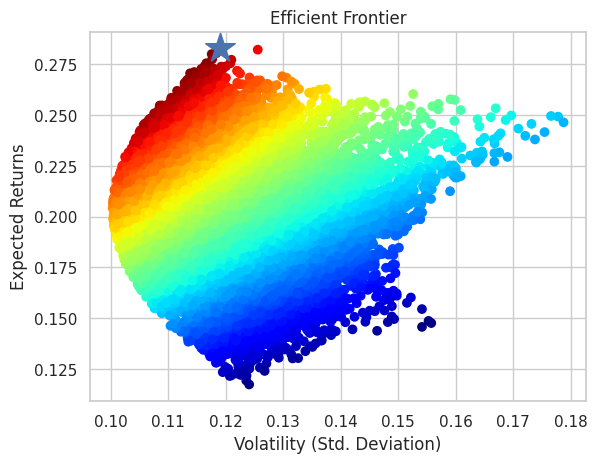

In [61]:
rets = np.sum(ret_daily.mean() * res['x']) * 250
vol = np.sqrt(res['x'].T @ covmat @ res['x'])
p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)
colors = p_returns/p_volatility


plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, rets, marker="*", s=500, alpha=1.0)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()